In [1]:
import tensorflow as tf
import os
import numpy as np
from pathlib import Path
from tensorflow import keras
from tensorflow.keras import layers
from tqdm import tqdm

2024-05-19 11:53:19.563199: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-19 11:53:19.563294: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-19 11:53:19.705523: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import os
# Define the path for the empty folder
folder_path = '/kaggle/working/empty_folderf3/'

# Create the empty folder
os.makedirs(folder_path, exist_ok=True)
save_dir = ('/kaggle/working/empty_folderf3')


In [3]:
from sklearn.model_selection import train_test_split

# Split dataset into training and validation sets
train_dir = '/kaggle/input/gtsrb-train/Train'
train_data, val_data = train_test_split(os.listdir(train_dir), test_size=0.2, random_state=42)

# Create training and validation datasets
train_dataset = keras.preprocessing.image_dataset_from_directory(
    directory=train_dir, 
    labels='inferred',  # Use inferred labels from directory structure
    label_mode='categorical', 
    image_size=(48, 48), 
    batch_size=64,
    shuffle=True,
    validation_split=0.2,  # Percentage of data to use for validation
    subset="training",
    seed=42  # Specify seed for reproducibility
).map(lambda x, y: (x/255.0, y))  # Normalize the pixel values to [0, 1]

val_dataset = keras.preprocessing.image_dataset_from_directory(
    directory=train_dir, 
    labels='inferred',  # Use inferred labels from directory structure
    label_mode='categorical', 
    image_size=(48, 48), 
    batch_size=64,
    shuffle=True,
    validation_split=0.2,  # Percentage of data to use for validation
    subset="validation",
    seed=42  # Specify seed for reproducibility
).map(lambda x, y: (x/255.0, y))  # Normalize the pixel values to [0, 1])


Found 39209 files belonging to 43 classes.
Using 31368 files for training.
Found 39209 files belonging to 43 classes.
Using 7841 files for validation.


In [4]:
#nnnnnnneeeeewwwwwwwwww   mmmmooodeeel

In [5]:
latent_dim = 128

# Encoder
encoder = keras.Sequential([
    layers.Input(shape=(48, 48, 3)),
    layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
    layers.LeakyReLU(0.2),
    layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
    layers.LeakyReLU(0.2),
    layers.Conv2D(256, kernel_size=4, strides=2, padding="same"),
    layers.LeakyReLU(0.2),
    layers.Conv2D(512, kernel_size=4, strides=2, padding="same"),
    layers.LeakyReLU(0.2),
    layers.Flatten(),
    layers.Dense(latent_dim)  # Latent representation
])

# Decoder
decoder = keras.Sequential([
    layers.Input(shape=(latent_dim,)),
    layers.Dense(6*6*512),
    layers.Reshape((6,6, 512)),
    layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
    layers.LeakyReLU(0.2),
    layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
    layers.LeakyReLU(0.2),
    layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding="same"),
    layers.LeakyReLU(0.2),
    layers.Conv2DTranspose(3, kernel_size=4,  padding="same", activation="tanh"),
])

# Full autoencoder model
autoencoder = keras.Sequential([
    layers.Input(shape=(48,48, 3)),
    encoder,
    decoder
])


In [6]:
from tensorflow.keras import layers, models, optimizers

In [7]:
import tensorflow as tf

def create_model():
    inputs = tf.keras.Input(shape=(48, 48, 3))
    
    x = tf.keras.layers.Conv2D(250, kernel_size=3, activation='relu', padding='same')(inputs)
    x = tf.keras.layers.MaxPooling2D(pool_size=2, padding='same')(x)  # Output shape: (24, 24, 250)
    
    x = tf.keras.layers.Conv2D(300, kernel_size=3, activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2, padding='same')(x)  # Output shape: (12, 12, 300)
    
    x = tf.keras.layers.Conv2D(350, kernel_size=3, activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2, padding='same')(x)  # Output shape: (6, 6, 350)
    
    x = tf.keras.layers.Conv2D(400, kernel_size=3, activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2, padding='same')(x)  # Output shape: (3, 3, 400)
    
    x = tf.keras.layers.Conv2D(450, kernel_size=3, activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2, padding='same')(x)  # Output shape: (2, 2, 450)
    
    x = tf.keras.layers.Flatten()(x)
    
    x = tf.keras.layers.Dense(450, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    x = tf.keras.layers.Dense(350, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    x = tf.keras.layers.Dense(250, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    x = tf.keras.layers.Dense(150, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    
    outputs = tf.keras.layers.Dense(43, activation='softmax')(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    return model

# Create an instance of the model
discriminator = create_model()




In [8]:
# Loss functions
loss_fn_auto = tf.keras.losses.MeanSquaredError()
loss_fn_disc = tf.keras.losses.CategoricalCrossentropy()

# Optimizers
opt_autoencoder = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5)
opt_disc = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5)


# Compile the autoencoder model
autoencoder.compile(optimizer=opt_autoencoder, loss=loss_fn_auto)

# Compile the discriminator model
discriminator.compile(optimizer=opt_disc, loss=loss_fn_disc, metrics=['accuracy'])

In [9]:
autoencoder_losses_epoch = []
discriminator_losses_epoch = []
discriminator_acc_epoch = []
val_autoencoder_losses_epoch = []
val_discriminator_losses_epoch = []
val_discriminator_acc_epoch = []

for epoch in range(100):
    # Initialize epoch-wise metrics
    epoch_autoencoder_losses = []
    epoch_discriminator_losses = []
    epoch_discriminator_acc = []
    epoch_val_autoencoder_losses = []
    epoch_val_discriminator_losses = []
    epoch_val_discriminator_acc = []

    # Training loop
    for idx, (batch_real, batch_label) in enumerate(tqdm(train_dataset)):
        # Training steps
        with tf.GradientTape() as autoencoder_tape, tf.GradientTape() as disc_tape:
            latent_representation = encoder(batch_real)
            generated_image = decoder(latent_representation)
            loss_autoencoder = loss_fn_auto(batch_real, generated_image)
            
            fake = generated_image
            loss_disc_real = loss_fn_disc(batch_label, discriminator(batch_real))
            loss_disc_fake = loss_fn_disc(batch_label, discriminator(fake))
            loss_disc = (loss_disc_real + loss_disc_fake) / 2

        grads_autoencoder = autoencoder_tape.gradient(loss_autoencoder, autoencoder.trainable_weights)
        opt_autoencoder.apply_gradients(zip(grads_autoencoder, autoencoder.trainable_weights))

        grads_discriminator = disc_tape.gradient(loss_disc, discriminator.trainable_weights)
        opt_disc.apply_gradients(zip(grads_discriminator, discriminator.trainable_weights))

        # Store batch-wise metrics
        epoch_autoencoder_losses.append(loss_autoencoder.numpy())
        epoch_discriminator_losses.append(loss_disc.numpy())
        epoch_discriminator_acc.append(tf.reduce_mean(tf.keras.metrics.categorical_accuracy(batch_label, discriminator(fake))).numpy())
        if idx % 200 == 0:
            img = tf.keras.preprocessing.image.array_to_img(fake[0])
            img.save(f"{save_dir}/generated_img_epoch_{epoch}_batch_{idx}.png")

    # Validation loop
    for val_batch_real, val_batch_label in val_dataset:
        val_latent_representation = encoder(val_batch_real)
        val_generated_image = decoder(val_latent_representation)
        val_loss_autoencoder = loss_fn_auto(val_batch_real, val_generated_image)
        val_loss_disc_real = loss_fn_disc(val_batch_label, discriminator(val_batch_real))
        val_loss_disc_fake = loss_fn_disc(val_batch_label, discriminator(val_generated_image))
        val_loss_disc = (val_loss_disc_real + val_loss_disc_fake) / 2

        # Calculate accuracy
        val_discriminator_accuracy = tf.reduce_mean(tf.keras.metrics.categorical_accuracy(val_batch_label, discriminator(val_generated_image)))

        # Store validation metrics
        epoch_val_autoencoder_losses.append(val_loss_autoencoder.numpy())
        epoch_val_discriminator_losses.append(val_loss_disc.numpy())
        epoch_val_discriminator_acc.append(val_discriminator_accuracy.numpy())

    # Calculate epoch-wise averages and append to the lists
    avg_autoencoder_loss = np.mean(epoch_autoencoder_losses)
    avg_discriminator_loss = np.mean(epoch_discriminator_losses)
    avg_discriminator_acc = np.mean(epoch_discriminator_acc)
    avg_val_autoencoder_loss = np.mean(epoch_val_autoencoder_losses)
    avg_val_discriminator_loss = np.mean(epoch_val_discriminator_losses)
    avg_val_discriminator_acc = np.mean(epoch_val_discriminator_acc)

    autoencoder_losses_epoch.append(avg_autoencoder_loss)
    discriminator_losses_epoch.append(avg_discriminator_loss)
    discriminator_acc_epoch.append(avg_discriminator_acc)
    val_autoencoder_losses_epoch.append(avg_val_autoencoder_loss)
    val_discriminator_losses_epoch.append(avg_val_discriminator_loss)
    val_discriminator_acc_epoch.append(avg_val_discriminator_acc)

    # Print epoch-wise metrics
    print(f"Epoch {epoch}, Autoencoder Loss: {avg_autoencoder_loss}, Discriminator Loss: {avg_discriminator_loss}, Discriminator Accuracy: {avg_discriminator_acc}")
    print(f"Validation - Autoencoder Loss: {avg_val_autoencoder_loss}, Discriminator Loss: {avg_val_discriminator_loss}, Discriminator Accuracy: {avg_val_discriminator_acc}")


100%|██████████| 491/491 [02:36<00:00,  3.14it/s]


Epoch 0, Autoencoder Loss: 0.0260771531611681, Discriminator Loss: 3.178070545196533, Discriminator Accuracy: 0.10813391208648682
Validation - Autoencoder Loss: 0.01685945689678192, Discriminator Loss: 2.56105899810791, Discriminator Accuracy: 0.11632329225540161


100%|██████████| 491/491 [02:23<00:00,  3.43it/s]


Epoch 1, Autoencoder Loss: 0.01231600996106863, Discriminator Loss: 1.4925650358200073, Discriminator Accuracy: 0.5416879057884216
Validation - Autoencoder Loss: 0.010455350391566753, Discriminator Loss: 1.0118328332901, Discriminator Accuracy: 0.596001923084259


100%|██████████| 491/491 [02:22<00:00,  3.45it/s]


Epoch 2, Autoencoder Loss: 0.008738884702324867, Discriminator Loss: 0.5899626612663269, Discriminator Accuracy: 0.8475050926208496
Validation - Autoencoder Loss: 0.007700140122324228, Discriminator Loss: 0.4256548583507538, Discriminator Accuracy: 0.8032651543617249


100%|██████████| 491/491 [02:24<00:00,  3.40it/s]


Epoch 3, Autoencoder Loss: 0.008912667632102966, Discriminator Loss: 0.3545142412185669, Discriminator Accuracy: 0.9191382527351379
Validation - Autoencoder Loss: 0.0067758746445178986, Discriminator Loss: 0.30058547854423523, Discriminator Accuracy: 0.8778178095817566


100%|██████████| 491/491 [02:21<00:00,  3.46it/s]


Epoch 4, Autoencoder Loss: 0.00621954258531332, Discriminator Loss: 0.15500539541244507, Discriminator Accuracy: 0.9817655086517334
Validation - Autoencoder Loss: 0.006103536579757929, Discriminator Loss: 0.549828827381134, Discriminator Accuracy: 0.819794774055481


100%|██████████| 491/491 [02:21<00:00,  3.47it/s]


Epoch 5, Autoencoder Loss: 0.005550737027078867, Discriminator Loss: 0.09605640918016434, Discriminator Accuracy: 0.9925216436386108
Validation - Autoencoder Loss: 0.005547430831938982, Discriminator Loss: 0.5636482834815979, Discriminator Accuracy: 0.8389535546302795


100%|██████████| 491/491 [02:21<00:00,  3.47it/s]


Epoch 6, Autoencoder Loss: 0.005021922755986452, Discriminator Loss: 0.06171180307865143, Discriminator Accuracy: 0.9976769089698792
Validation - Autoencoder Loss: 0.00516454828903079, Discriminator Loss: 0.10298169404268265, Discriminator Accuracy: 0.9541412591934204


100%|██████████| 491/491 [02:21<00:00,  3.47it/s]


Epoch 7, Autoencoder Loss: 0.005032666493207216, Discriminator Loss: 0.07620591670274734, Discriminator Accuracy: 0.9926807284355164
Validation - Autoencoder Loss: 0.004728782456368208, Discriminator Loss: 0.15524451434612274, Discriminator Accuracy: 0.9288617968559265


100%|██████████| 491/491 [02:22<00:00,  3.44it/s]


Epoch 8, Autoencoder Loss: 0.004208885133266449, Discriminator Loss: 0.03353128954768181, Discriminator Accuracy: 0.9990771412849426
Validation - Autoencoder Loss: 0.004718853626400232, Discriminator Loss: 0.08739253878593445, Discriminator Accuracy: 0.9652084708213806


100%|██████████| 491/491 [03:21<00:00,  2.43it/s]


Epoch 9, Autoencoder Loss: 0.0040077450685203075, Discriminator Loss: 0.02672126702964306, Discriminator Accuracy: 0.999586284160614
Validation - Autoencoder Loss: 0.004430963192135096, Discriminator Loss: 0.08287481963634491, Discriminator Accuracy: 0.9639227390289307


100%|██████████| 491/491 [02:24<00:00,  3.40it/s]


Epoch 10, Autoencoder Loss: 0.003753827651962638, Discriminator Loss: 0.027802783995866776, Discriminator Accuracy: 0.9993953704833984
Validation - Autoencoder Loss: 0.004014395177364349, Discriminator Loss: 0.06131400540471077, Discriminator Accuracy: 0.976760745048523


100%|██████████| 491/491 [02:24<00:00,  3.41it/s]


Epoch 11, Autoencoder Loss: 0.003603981342166662, Discriminator Loss: 0.025142552331089973, Discriminator Accuracy: 0.9990771412849426
Validation - Autoencoder Loss: 0.00352649693377316, Discriminator Loss: 0.07028956711292267, Discriminator Accuracy: 0.9772611856460571


100%|██████████| 491/491 [02:24<00:00,  3.41it/s]


Epoch 12, Autoencoder Loss: 0.0033898192923516035, Discriminator Loss: 0.02240225300192833, Discriminator Accuracy: 0.9992680549621582
Validation - Autoencoder Loss: 0.0034928040113300085, Discriminator Loss: 0.046763017773628235, Discriminator Accuracy: 0.9837398529052734


100%|██████████| 491/491 [02:23<00:00,  3.41it/s]


Epoch 13, Autoencoder Loss: 0.003296631621196866, Discriminator Loss: 0.01738586090505123, Discriminator Accuracy: 0.9992362260818481
Validation - Autoencoder Loss: 0.003890790743753314, Discriminator Loss: 0.10740838944911957, Discriminator Accuracy: 0.9521164298057556


100%|██████████| 491/491 [02:24<00:00,  3.39it/s]


Epoch 14, Autoencoder Loss: 0.0031612764578312635, Discriminator Loss: 0.0300887543708086, Discriminator Accuracy: 0.9987589120864868
Validation - Autoencoder Loss: 0.003585720667615533, Discriminator Loss: 0.04026295989751816, Discriminator Accuracy: 0.985264241695404


100%|██████████| 491/491 [02:23<00:00,  3.41it/s]


Epoch 15, Autoencoder Loss: 0.002988601103425026, Discriminator Loss: 0.010569049045443535, Discriminator Accuracy: 0.9997772574424744
Validation - Autoencoder Loss: 0.003209533402696252, Discriminator Loss: 0.044549476355314255, Discriminator Accuracy: 0.9837398529052734


100%|██████████| 491/491 [02:23<00:00,  3.42it/s]


Epoch 16, Autoencoder Loss: 0.0029673129320144653, Discriminator Loss: 0.024674739688634872, Discriminator Accuracy: 0.9984725117683411
Validation - Autoencoder Loss: 0.0032612858340144157, Discriminator Loss: 0.04724320024251938, Discriminator Accuracy: 0.9839938879013062


100%|██████████| 491/491 [03:21<00:00,  2.43it/s]


Epoch 17, Autoencoder Loss: 0.002824756782501936, Discriminator Loss: 0.011150983162224293, Discriminator Accuracy: 0.999586284160614
Validation - Autoencoder Loss: 0.0030785128474235535, Discriminator Loss: 0.06120605394244194, Discriminator Accuracy: 0.9766337275505066


100%|██████████| 491/491 [02:24<00:00,  3.40it/s]


Epoch 18, Autoencoder Loss: 0.0027192735578864813, Discriminator Loss: 0.016657298430800438, Discriminator Accuracy: 0.9995226860046387
Validation - Autoencoder Loss: 0.0029795877635478973, Discriminator Loss: 0.07088395208120346, Discriminator Accuracy: 0.9753556847572327


100%|██████████| 491/491 [02:24<00:00,  3.39it/s]


Epoch 19, Autoencoder Loss: 0.002657089149579406, Discriminator Loss: 0.013259444385766983, Discriminator Accuracy: 0.9998090863227844
Validation - Autoencoder Loss: 0.0031347298063337803, Discriminator Loss: 0.05929350480437279, Discriminator Accuracy: 0.9786662459373474


100%|██████████| 491/491 [02:24<00:00,  3.40it/s]


Epoch 20, Autoencoder Loss: 0.002615935867652297, Discriminator Loss: 0.010236133821308613, Discriminator Accuracy: 0.9996499419212341
Validation - Autoencoder Loss: 0.003510551992803812, Discriminator Loss: 0.045739881694316864, Discriminator Accuracy: 0.981834352016449


100%|██████████| 491/491 [02:24<00:00,  3.40it/s]


Epoch 21, Autoencoder Loss: 0.0025436757132411003, Discriminator Loss: 0.010381169617176056, Discriminator Accuracy: 0.9995226860046387
Validation - Autoencoder Loss: 0.0030298091005533934, Discriminator Loss: 0.048751700669527054, Discriminator Accuracy: 0.9837398529052734


100%|██████████| 491/491 [02:24<00:00,  3.39it/s]


Epoch 22, Autoencoder Loss: 0.0024834636133164167, Discriminator Loss: 0.011204750277101994, Discriminator Accuracy: 0.9998090863227844
Validation - Autoencoder Loss: 0.0029975909274071455, Discriminator Loss: 0.04307440295815468, Discriminator Accuracy: 0.9851449131965637


100%|██████████| 491/491 [02:23<00:00,  3.41it/s]


Epoch 23, Autoencoder Loss: 0.0024204468354582787, Discriminator Loss: 0.012743914499878883, Discriminator Accuracy: 0.999554455280304
Validation - Autoencoder Loss: 0.0028212799225002527, Discriminator Loss: 0.03803832456469536, Discriminator Accuracy: 0.9857723712921143


100%|██████████| 491/491 [02:22<00:00,  3.45it/s]


Epoch 24, Autoencoder Loss: 0.002384765539318323, Discriminator Loss: 0.008851734921336174, Discriminator Accuracy: 0.9998090863227844
Validation - Autoencoder Loss: 0.0027596394065767527, Discriminator Loss: 0.04144822806119919, Discriminator Accuracy: 0.9855182766914368


100%|██████████| 491/491 [02:22<00:00,  3.45it/s]


Epoch 25, Autoencoder Loss: 0.002323252148926258, Discriminator Loss: 0.01602206751704216, Discriminator Accuracy: 0.9996817708015442
Validation - Autoencoder Loss: 0.003219584235921502, Discriminator Loss: 0.0676058903336525, Discriminator Accuracy: 0.9739660024642944


100%|██████████| 491/491 [02:25<00:00,  3.38it/s]


Epoch 26, Autoencoder Loss: 0.0023230798542499542, Discriminator Loss: 0.00658218702301383, Discriminator Accuracy: 0.9997772574424744
Validation - Autoencoder Loss: 0.002978661097586155, Discriminator Loss: 0.0379021093249321, Discriminator Accuracy: 0.9878048896789551


100%|██████████| 491/491 [02:22<00:00,  3.44it/s]


Epoch 27, Autoencoder Loss: 0.002227823017165065, Discriminator Loss: 0.006099758204072714, Discriminator Accuracy: 0.9998409152030945
Validation - Autoencoder Loss: 0.0029300320893526077, Discriminator Loss: 0.10425076633691788, Discriminator Accuracy: 0.9648119807243347


100%|██████████| 491/491 [02:23<00:00,  3.43it/s]


Epoch 28, Autoencoder Loss: 0.0022165144328027964, Discriminator Loss: 0.010803702287375927, Discriminator Accuracy: 0.9996817708015442
Validation - Autoencoder Loss: 0.0026809140108525753, Discriminator Loss: 0.0391588993370533, Discriminator Accuracy: 0.9879319071769714


100%|██████████| 491/491 [02:24<00:00,  3.40it/s]


Epoch 29, Autoencoder Loss: 0.002158550312742591, Discriminator Loss: 0.007601585704833269, Discriminator Accuracy: 0.9999045133590698
Validation - Autoencoder Loss: 0.0027108772192150354, Discriminator Loss: 0.05818882957100868, Discriminator Accuracy: 0.9802060127258301


100%|██████████| 491/491 [02:23<00:00,  3.42it/s]


Epoch 30, Autoencoder Loss: 0.00213438062928617, Discriminator Loss: 0.004413020331412554, Discriminator Accuracy: 0.9998726844787598
Validation - Autoencoder Loss: 0.002611975884065032, Discriminator Loss: 0.04426148161292076, Discriminator Accuracy: 0.9820883870124817


100%|██████████| 491/491 [02:23<00:00,  3.43it/s]


Epoch 31, Autoencoder Loss: 0.002098460216075182, Discriminator Loss: 0.009065735153853893, Discriminator Accuracy: 0.999586284160614
Validation - Autoencoder Loss: 0.0029184070881456137, Discriminator Loss: 0.37000250816345215, Discriminator Accuracy: 0.9513465166091919


100%|██████████| 491/491 [02:22<00:00,  3.45it/s]


Epoch 32, Autoencoder Loss: 0.0020588585175573826, Discriminator Loss: 0.014014335349202156, Discriminator Accuracy: 0.9998409152030945
Validation - Autoencoder Loss: 0.002719584619626403, Discriminator Loss: 0.06694461405277252, Discriminator Accuracy: 0.9770224690437317


100%|██████████| 491/491 [02:22<00:00,  3.44it/s]


Epoch 33, Autoencoder Loss: 0.0020382560323923826, Discriminator Loss: 0.0050252508372068405, Discriminator Accuracy: 0.9997772574424744
Validation - Autoencoder Loss: 0.003663330804556608, Discriminator Loss: 0.06744911521673203, Discriminator Accuracy: 0.979301393032074


100%|██████████| 491/491 [02:22<00:00,  3.44it/s]


Epoch 34, Autoencoder Loss: 0.002025951398536563, Discriminator Loss: 0.00603002542629838, Discriminator Accuracy: 0.9997454285621643
Validation - Autoencoder Loss: 0.0027603679336607456, Discriminator Loss: 0.03239194303750992, Discriminator Accuracy: 0.9884554147720337


100%|██████████| 491/491 [02:23<00:00,  3.43it/s]


Epoch 35, Autoencoder Loss: 0.0019530801801010966, Discriminator Loss: 0.0045150574296712875, Discriminator Accuracy: 0.9999363422393799
Validation - Autoencoder Loss: 0.003412001533433795, Discriminator Loss: 0.06693826615810394, Discriminator Accuracy: 0.972576379776001


100%|██████████| 491/491 [02:22<00:00,  3.44it/s]


Epoch 36, Autoencoder Loss: 0.0019422683399170637, Discriminator Loss: 0.001824309234507382, Discriminator Accuracy: 1.0
Validation - Autoencoder Loss: 0.002599154831841588, Discriminator Loss: 0.03176988288760185, Discriminator Accuracy: 0.9913617968559265


100%|██████████| 491/491 [02:23<00:00,  3.41it/s]


Epoch 37, Autoencoder Loss: 0.001915536355227232, Discriminator Loss: 0.00942907389253378, Discriminator Accuracy: 0.9996181130409241
Validation - Autoencoder Loss: 0.002687075873836875, Discriminator Loss: 0.047634150832891464, Discriminator Accuracy: 0.981834352016449


100%|██████████| 491/491 [02:22<00:00,  3.45it/s]


Epoch 38, Autoencoder Loss: 0.0018875534879043698, Discriminator Loss: 0.00958149041980505, Discriminator Accuracy: 0.9998726844787598
Validation - Autoencoder Loss: 0.002773028565570712, Discriminator Loss: 0.03553728759288788, Discriminator Accuracy: 0.986915647983551


100%|██████████| 491/491 [02:22<00:00,  3.44it/s]


Epoch 39, Autoencoder Loss: 0.0018711020238697529, Discriminator Loss: 0.005888539832085371, Discriminator Accuracy: 0.9999045133590698
Validation - Autoencoder Loss: 0.0026405234821140766, Discriminator Loss: 0.03429466485977173, Discriminator Accuracy: 0.989456295967102


100%|██████████| 491/491 [02:22<00:00,  3.44it/s]


Epoch 40, Autoencoder Loss: 0.0018521734746173024, Discriminator Loss: 0.003268094267696142, Discriminator Accuracy: 0.9999045133590698
Validation - Autoencoder Loss: 0.0026669383514672518, Discriminator Loss: 0.028079258278012276, Discriminator Accuracy: 0.9900914430618286


100%|██████████| 491/491 [03:21<00:00,  2.43it/s]


Epoch 41, Autoencoder Loss: 0.0018167223315685987, Discriminator Loss: 0.003754224395379424, Discriminator Accuracy: 0.9998726844787598
Validation - Autoencoder Loss: 0.0026721556205302477, Discriminator Loss: 0.03775245323777199, Discriminator Accuracy: 0.9893292784690857


100%|██████████| 491/491 [02:21<00:00,  3.46it/s]


Epoch 42, Autoencoder Loss: 0.0017974479123950005, Discriminator Loss: 0.007461210712790489, Discriminator Accuracy: 0.9999045133590698
Validation - Autoencoder Loss: 0.002647395944222808, Discriminator Loss: 0.03828783333301544, Discriminator Accuracy: 0.9865345358848572


100%|██████████| 491/491 [02:22<00:00,  3.44it/s]


Epoch 43, Autoencoder Loss: 0.001774518401362002, Discriminator Loss: 0.008403907530009747, Discriminator Accuracy: 0.9998726844787598
Validation - Autoencoder Loss: 0.002575908089056611, Discriminator Loss: 0.036742620170116425, Discriminator Accuracy: 0.9874237775802612


100%|██████████| 491/491 [03:21<00:00,  2.43it/s]


Epoch 44, Autoencoder Loss: 0.001770833390764892, Discriminator Loss: 0.0022096079774200916, Discriminator Accuracy: 0.9999363422393799
Validation - Autoencoder Loss: 0.00256155151873827, Discriminator Loss: 0.028481265529990196, Discriminator Accuracy: 0.991107702255249


100%|██████████| 491/491 [02:21<00:00,  3.46it/s]


Epoch 45, Autoencoder Loss: 0.001738596591167152, Discriminator Loss: 0.00599895603954792, Discriminator Accuracy: 0.9998726844787598
Validation - Autoencoder Loss: 0.002550887642428279, Discriminator Loss: 0.03500963747501373, Discriminator Accuracy: 0.9884400367736816


100%|██████████| 491/491 [02:22<00:00,  3.44it/s]


Epoch 46, Autoencoder Loss: 0.0017162398435175419, Discriminator Loss: 0.0034518965985625982, Discriminator Accuracy: 0.9996499419212341
Validation - Autoencoder Loss: 0.0026162087451666594, Discriminator Loss: 0.38906049728393555, Discriminator Accuracy: 0.9456300735473633


100%|██████████| 491/491 [02:24<00:00,  3.41it/s]


Epoch 47, Autoencoder Loss: 0.0016909325495362282, Discriminator Loss: 0.006233074702322483, Discriminator Accuracy: 0.9999681711196899
Validation - Autoencoder Loss: 0.0027696602046489716, Discriminator Loss: 0.039514731615781784, Discriminator Accuracy: 0.9857877492904663


100%|██████████| 491/491 [02:22<00:00,  3.45it/s]


Epoch 48, Autoencoder Loss: 0.0016907677054405212, Discriminator Loss: 0.001641471404582262, Discriminator Accuracy: 0.9999681711196899
Validation - Autoencoder Loss: 0.002585343085229397, Discriminator Loss: 0.03613566234707832, Discriminator Accuracy: 0.989456295967102


100%|██████████| 491/491 [02:22<00:00,  3.45it/s]


Epoch 49, Autoencoder Loss: 0.001663506613112986, Discriminator Loss: 0.00011522744898684323, Discriminator Accuracy: 1.0
Validation - Autoencoder Loss: 0.0031097829341888428, Discriminator Loss: 0.04666219651699066, Discriminator Accuracy: 0.9870503544807434


100%|██████████| 491/491 [02:21<00:00,  3.46it/s]


Epoch 50, Autoencoder Loss: 0.0016523414524272084, Discriminator Loss: 0.009982232004404068, Discriminator Accuracy: 0.9996817708015442
Validation - Autoencoder Loss: 0.0026007629930973053, Discriminator Loss: 0.034803606569767, Discriminator Accuracy: 0.989456295967102


100%|██████████| 491/491 [02:23<00:00,  3.43it/s]


Epoch 51, Autoencoder Loss: 0.001629465725272894, Discriminator Loss: 0.0057112243957817554, Discriminator Accuracy: 0.9997772574424744
Validation - Autoencoder Loss: 0.0025800380390137434, Discriminator Loss: 0.03532242402434349, Discriminator Accuracy: 0.9890828728675842


100%|██████████| 491/491 [02:22<00:00,  3.45it/s]


Epoch 52, Autoencoder Loss: 0.001639011548832059, Discriminator Loss: 0.0050070094875991344, Discriminator Accuracy: 0.9997772574424744
Validation - Autoencoder Loss: 0.0030116599518805742, Discriminator Loss: 0.04290129244327545, Discriminator Accuracy: 0.9849061965942383


100%|██████████| 491/491 [02:22<00:00,  3.44it/s]


Epoch 53, Autoencoder Loss: 0.0016033469000831246, Discriminator Loss: 0.0033918048720806837, Discriminator Accuracy: 1.0
Validation - Autoencoder Loss: 0.0027657593600451946, Discriminator Loss: 0.033995892852544785, Discriminator Accuracy: 0.9889481663703918


100%|██████████| 491/491 [02:23<00:00,  3.41it/s]


Epoch 54, Autoencoder Loss: 0.0015911409864202142, Discriminator Loss: 0.0078396862372756, Discriminator Accuracy: 0.9996181130409241
Validation - Autoencoder Loss: 0.0030148199293762445, Discriminator Loss: 0.04093547537922859, Discriminator Accuracy: 0.9850101470947266


100%|██████████| 491/491 [02:22<00:00,  3.45it/s]


Epoch 55, Autoencoder Loss: 0.0016230478649958968, Discriminator Loss: 0.00616602273657918, Discriminator Accuracy: 0.9996817708015442
Validation - Autoencoder Loss: 0.0026471521705389023, Discriminator Loss: 0.03528884798288345, Discriminator Accuracy: 0.9875507950782776


100%|██████████| 491/491 [02:23<00:00,  3.41it/s]


Epoch 56, Autoencoder Loss: 0.0015658398624509573, Discriminator Loss: 0.002440952230244875, Discriminator Accuracy: 0.9999681711196899
Validation - Autoencoder Loss: 0.002590546850115061, Discriminator Loss: 0.03121066652238369, Discriminator Accuracy: 0.9913617968559265


100%|██████████| 491/491 [02:22<00:00,  3.43it/s]


Epoch 57, Autoencoder Loss: 0.0015431108186021447, Discriminator Loss: 0.00023916676582302898, Discriminator Accuracy: 1.0
Validation - Autoencoder Loss: 0.0026310193352401257, Discriminator Loss: 0.046905796974897385, Discriminator Accuracy: 0.9865345358848572


100%|██████████| 491/491 [02:22<00:00,  3.46it/s]


Epoch 58, Autoencoder Loss: 0.0015452286461368203, Discriminator Loss: 0.001785671804100275, Discriminator Accuracy: 0.9999681711196899
Validation - Autoencoder Loss: 0.002679692581295967, Discriminator Loss: 0.036797892302274704, Discriminator Accuracy: 0.9893292784690857


100%|██████████| 491/491 [02:22<00:00,  3.44it/s]


Epoch 59, Autoencoder Loss: 0.0015291441231966019, Discriminator Loss: 0.007343531120568514, Discriminator Accuracy: 0.9998090863227844
Validation - Autoencoder Loss: 0.0027261381037533283, Discriminator Loss: 0.03537290543317795, Discriminator Accuracy: 0.9881860017776489


100%|██████████| 491/491 [02:23<00:00,  3.41it/s]


Epoch 60, Autoencoder Loss: 0.0015210302080959082, Discriminator Loss: 0.004566645715385675, Discriminator Accuracy: 0.9998409152030945
Validation - Autoencoder Loss: 0.002652101218700409, Discriminator Loss: 0.03180116415023804, Discriminator Accuracy: 0.9909806847572327


100%|██████████| 491/491 [02:22<00:00,  3.44it/s]


Epoch 61, Autoencoder Loss: 0.001516676158644259, Discriminator Loss: 0.0014695493737235665, Discriminator Accuracy: 1.0
Validation - Autoencoder Loss: 0.002622180385515094, Discriminator Loss: 0.03075028769671917, Discriminator Accuracy: 0.9895833134651184


100%|██████████| 491/491 [02:22<00:00,  3.45it/s]


Epoch 62, Autoencoder Loss: 0.0014884494012221694, Discriminator Loss: 0.0038481790106743574, Discriminator Accuracy: 0.9999045133590698
Validation - Autoencoder Loss: 0.0030589813832193613, Discriminator Loss: 0.02831299975514412, Discriminator Accuracy: 0.9908536672592163


100%|██████████| 491/491 [02:21<00:00,  3.46it/s]


Epoch 63, Autoencoder Loss: 0.0014920930843800306, Discriminator Loss: 0.0039198859594762325, Discriminator Accuracy: 0.9999363422393799
Validation - Autoencoder Loss: 0.0025976516772061586, Discriminator Loss: 0.03543153032660484, Discriminator Accuracy: 0.9876778721809387


100%|██████████| 491/491 [02:23<00:00,  3.43it/s]


Epoch 64, Autoencoder Loss: 0.001477241748943925, Discriminator Loss: 0.008680393919348717, Discriminator Accuracy: 0.9997454285621643
Validation - Autoencoder Loss: 0.0026104794815182686, Discriminator Loss: 0.03272271901369095, Discriminator Accuracy: 0.9880589246749878


100%|██████████| 491/491 [02:22<00:00,  3.45it/s]


Epoch 65, Autoencoder Loss: 0.0014663904439657927, Discriminator Loss: 0.0025104694068431854, Discriminator Accuracy: 0.9999363422393799
Validation - Autoencoder Loss: 0.00293741375207901, Discriminator Loss: 0.1010027676820755, Discriminator Accuracy: 0.9735849499702454


100%|██████████| 491/491 [02:22<00:00,  3.45it/s]


Epoch 66, Autoencoder Loss: 0.001454437617212534, Discriminator Loss: 0.0052239359356462955, Discriminator Accuracy: 0.9999681711196899
Validation - Autoencoder Loss: 0.0028086744714528322, Discriminator Loss: 0.03718144819140434, Discriminator Accuracy: 0.9872967600822449


100%|██████████| 491/491 [02:23<00:00,  3.41it/s]


Epoch 67, Autoencoder Loss: 0.001451778574846685, Discriminator Loss: 0.0008398013887926936, Discriminator Accuracy: 1.0
Validation - Autoencoder Loss: 0.0026409190613776445, Discriminator Loss: 0.032701555639505386, Discriminator Accuracy: 0.9904725551605225


100%|██████████| 491/491 [02:23<00:00,  3.42it/s]


Epoch 68, Autoencoder Loss: 0.0014578723348677158, Discriminator Loss: 0.0017950002802535892, Discriminator Accuracy: 1.0
Validation - Autoencoder Loss: 0.002575756050646305, Discriminator Loss: 0.03687111660838127, Discriminator Accuracy: 0.9895833134651184


100%|██████████| 491/491 [02:23<00:00,  3.43it/s]


Epoch 69, Autoencoder Loss: 0.0014106478774920106, Discriminator Loss: 0.002361853141337633, Discriminator Accuracy: 1.0
Validation - Autoencoder Loss: 0.002918815705925226, Discriminator Loss: 0.03370564430952072, Discriminator Accuracy: 0.9884400367736816


100%|██████████| 491/491 [02:24<00:00,  3.40it/s]


Epoch 70, Autoencoder Loss: 0.001412867335602641, Discriminator Loss: 0.006818623747676611, Discriminator Accuracy: 0.9998090863227844
Validation - Autoencoder Loss: 0.0027094127144664526, Discriminator Loss: 0.03292093798518181, Discriminator Accuracy: 0.989456295967102


100%|██████████| 491/491 [02:24<00:00,  3.41it/s]


Epoch 71, Autoencoder Loss: 0.0014082338893786073, Discriminator Loss: 0.002176768146455288, Discriminator Accuracy: 1.0
Validation - Autoencoder Loss: 0.002700842684134841, Discriminator Loss: 0.03934314474463463, Discriminator Accuracy: 0.988567054271698


100%|██████████| 491/491 [02:23<00:00,  3.42it/s]


Epoch 72, Autoencoder Loss: 0.0014056687941774726, Discriminator Loss: 0.0021851176861673594, Discriminator Accuracy: 1.0
Validation - Autoencoder Loss: 0.0026361318305134773, Discriminator Loss: 0.04281047359108925, Discriminator Accuracy: 0.9865422248840332


100%|██████████| 491/491 [02:24<00:00,  3.39it/s]


Epoch 73, Autoencoder Loss: 0.0013951014261692762, Discriminator Loss: 0.0025760456919670105, Discriminator Accuracy: 0.9999363422393799
Validation - Autoencoder Loss: 0.0028596711345016956, Discriminator Loss: 0.03370551019906998, Discriminator Accuracy: 0.9897103905677795


100%|██████████| 491/491 [02:22<00:00,  3.45it/s]


Epoch 74, Autoencoder Loss: 0.00138682103715837, Discriminator Loss: 0.0035268699284642935, Discriminator Accuracy: 0.9999681711196899
Validation - Autoencoder Loss: 0.0026356203015893698, Discriminator Loss: 0.034369096159935, Discriminator Accuracy: 0.9892099499702454


100%|██████████| 491/491 [02:23<00:00,  3.43it/s]


Epoch 75, Autoencoder Loss: 0.001378645421937108, Discriminator Loss: 0.0008962295250967145, Discriminator Accuracy: 1.0
Validation - Autoencoder Loss: 0.002513354178518057, Discriminator Loss: 0.03375517949461937, Discriminator Accuracy: 0.9897180795669556


100%|██████████| 491/491 [02:23<00:00,  3.42it/s]


Epoch 76, Autoencoder Loss: 0.0013717437395825982, Discriminator Loss: 0.0018657422624528408, Discriminator Accuracy: 0.9999363422393799
Validation - Autoencoder Loss: 0.002589368959888816, Discriminator Loss: 0.028484685346484184, Discriminator Accuracy: 0.9913617968559265


100%|██████████| 491/491 [02:21<00:00,  3.46it/s]


Epoch 77, Autoencoder Loss: 0.0013597829965874553, Discriminator Loss: 5.770066491095349e-05, Discriminator Accuracy: 1.0
Validation - Autoencoder Loss: 0.0025969070848077536, Discriminator Loss: 0.03124864213168621, Discriminator Accuracy: 0.9914888143539429


100%|██████████| 491/491 [02:22<00:00,  3.44it/s]


Epoch 78, Autoencoder Loss: 0.0013591413153335452, Discriminator Loss: 0.005740238353610039, Discriminator Accuracy: 0.9997772574424744
Validation - Autoencoder Loss: 0.002629851456731558, Discriminator Loss: 0.5439088344573975, Discriminator Accuracy: 0.9470351338386536


100%|██████████| 491/491 [02:24<00:00,  3.39it/s]


Epoch 79, Autoencoder Loss: 0.0013445584336295724, Discriminator Loss: 0.005381005350500345, Discriminator Accuracy: 0.9999681711196899
Validation - Autoencoder Loss: 0.0027372371405363083, Discriminator Loss: 0.036962930113077164, Discriminator Accuracy: 0.9888211488723755


100%|██████████| 491/491 [02:28<00:00,  3.32it/s]


Epoch 80, Autoencoder Loss: 0.0013443647185340524, Discriminator Loss: 0.0006472660461440682, Discriminator Accuracy: 1.0
Validation - Autoencoder Loss: 0.0026207182090729475, Discriminator Loss: 0.03803005814552307, Discriminator Accuracy: 0.9902185201644897


100%|██████████| 491/491 [02:24<00:00,  3.41it/s]


Epoch 81, Autoencoder Loss: 0.0013398226583376527, Discriminator Loss: 0.00034596017212606966, Discriminator Accuracy: 1.0
Validation - Autoencoder Loss: 0.0026921401731669903, Discriminator Loss: 0.04537428915500641, Discriminator Accuracy: 0.9893369674682617


100%|██████████| 491/491 [02:25<00:00,  3.38it/s]


Epoch 82, Autoencoder Loss: 0.0013329657958820462, Discriminator Loss: 0.007509548217058182, Discriminator Accuracy: 0.9998090863227844
Validation - Autoencoder Loss: 0.002756771631538868, Discriminator Loss: 0.03577572479844093, Discriminator Accuracy: 0.9893369674682617


100%|██████████| 491/491 [02:21<00:00,  3.46it/s]


Epoch 83, Autoencoder Loss: 0.0013347406638786197, Discriminator Loss: 0.0010012945858761668, Discriminator Accuracy: 0.9999681711196899
Validation - Autoencoder Loss: 0.0025795528199523687, Discriminator Loss: 0.03278828784823418, Discriminator Accuracy: 0.9902185201644897


100%|██████████| 491/491 [02:22<00:00,  3.45it/s]


Epoch 84, Autoencoder Loss: 0.0012997225858271122, Discriminator Loss: 5.569458517129533e-05, Discriminator Accuracy: 1.0
Validation - Autoencoder Loss: 0.002525579184293747, Discriminator Loss: 0.03462868556380272, Discriminator Accuracy: 0.9912424683570862


100%|██████████| 491/491 [02:22<00:00,  3.45it/s]


Epoch 85, Autoencoder Loss: 0.001321232644841075, Discriminator Loss: 0.003180673811584711, Discriminator Accuracy: 0.9999045133590698
Validation - Autoencoder Loss: 0.0025329513009637594, Discriminator Loss: 0.03456348553299904, Discriminator Accuracy: 0.9887018203735352


100%|██████████| 491/491 [02:22<00:00,  3.44it/s]


Epoch 86, Autoencoder Loss: 0.0013041719794273376, Discriminator Loss: 0.004296260420233011, Discriminator Accuracy: 0.9999681711196899
Validation - Autoencoder Loss: 0.0029577005188912153, Discriminator Loss: 0.03399607911705971, Discriminator Accuracy: 0.989456295967102


100%|██████████| 491/491 [02:22<00:00,  3.45it/s]


Epoch 87, Autoencoder Loss: 0.0013016482116654515, Discriminator Loss: 0.003363484051078558, Discriminator Accuracy: 0.9999045133590698
Validation - Autoencoder Loss: 0.002641757018864155, Discriminator Loss: 0.036020033061504364, Discriminator Accuracy: 0.9886941313743591


100%|██████████| 491/491 [02:22<00:00,  3.44it/s]


Epoch 88, Autoencoder Loss: 0.0012854539090767503, Discriminator Loss: 0.0012482007732614875, Discriminator Accuracy: 0.9999681711196899
Validation - Autoencoder Loss: 0.0025395306292921305, Discriminator Loss: 0.02815917506814003, Discriminator Accuracy: 0.9908536672592163


100%|██████████| 491/491 [02:21<00:00,  3.46it/s]


Epoch 89, Autoencoder Loss: 0.0012949383817613125, Discriminator Loss: 0.0013858580496162176, Discriminator Accuracy: 1.0
Validation - Autoencoder Loss: 0.002730404492467642, Discriminator Loss: 0.034395474940538406, Discriminator Accuracy: 0.9889481663703918


100%|██████████| 491/491 [02:21<00:00,  3.46it/s]


Epoch 90, Autoencoder Loss: 0.0012734794290736318, Discriminator Loss: 0.0036048393230885267, Discriminator Accuracy: 0.9999681711196899
Validation - Autoencoder Loss: 0.002660052850842476, Discriminator Loss: 0.04854434356093407, Discriminator Accuracy: 0.9861688613891602


100%|██████████| 491/491 [02:22<00:00,  3.45it/s]


Epoch 91, Autoencoder Loss: 0.0012753314804285765, Discriminator Loss: 0.002300853608176112, Discriminator Accuracy: 1.0
Validation - Autoencoder Loss: 0.002564407652243972, Discriminator Loss: 0.034744568169116974, Discriminator Accuracy: 0.9889481663703918


100%|██████████| 491/491 [03:21<00:00,  2.43it/s]


Epoch 92, Autoencoder Loss: 0.0012660196516662836, Discriminator Loss: 0.0014403274981305003, Discriminator Accuracy: 0.9999363422393799
Validation - Autoencoder Loss: 0.0026799263432621956, Discriminator Loss: 0.032426103949546814, Discriminator Accuracy: 0.9907266497612


100%|██████████| 491/491 [02:21<00:00,  3.47it/s]


Epoch 93, Autoencoder Loss: 0.0012680299114435911, Discriminator Loss: 0.0016373320249840617, Discriminator Accuracy: 1.0
Validation - Autoencoder Loss: 0.002568882191553712, Discriminator Loss: 0.029470527544617653, Discriminator Accuracy: 0.9908536672592163


100%|██████████| 491/491 [02:21<00:00,  3.47it/s]


Epoch 94, Autoencoder Loss: 0.0012616817839443684, Discriminator Loss: 0.001611954066902399, Discriminator Accuracy: 0.9999681711196899
Validation - Autoencoder Loss: 0.002575563732534647, Discriminator Loss: 0.04347999766469002, Discriminator Accuracy: 0.9867886304855347


100%|██████████| 491/491 [02:22<00:00,  3.46it/s]


Epoch 95, Autoencoder Loss: 0.0012512591201812029, Discriminator Loss: 0.002448835177347064, Discriminator Accuracy: 1.0
Validation - Autoencoder Loss: 0.0026429002173244953, Discriminator Loss: 0.031491465866565704, Discriminator Accuracy: 0.9921239614486694


100%|██████████| 491/491 [02:21<00:00,  3.47it/s]


Epoch 96, Autoencoder Loss: 0.001243271748535335, Discriminator Loss: 0.004432630259543657, Discriminator Accuracy: 0.9999045133590698
Validation - Autoencoder Loss: 0.0026084769051522017, Discriminator Loss: 0.05019271746277809, Discriminator Accuracy: 0.9828659892082214


100%|██████████| 491/491 [02:21<00:00,  3.47it/s]


Epoch 97, Autoencoder Loss: 0.001281533855944872, Discriminator Loss: 0.002094476716592908, Discriminator Accuracy: 0.9999363422393799
Validation - Autoencoder Loss: 0.0025460466276854277, Discriminator Loss: 0.03135509416460991, Discriminator Accuracy: 0.9927591681480408


100%|██████████| 491/491 [02:21<00:00,  3.48it/s]


Epoch 98, Autoencoder Loss: 0.0012151170521974564, Discriminator Loss: 0.003126713912934065, Discriminator Accuracy: 0.9998726844787598
Validation - Autoencoder Loss: 0.002918767975643277, Discriminator Loss: 0.051669709384441376, Discriminator Accuracy: 0.9848908185958862


100%|██████████| 491/491 [02:22<00:00,  3.45it/s]


Epoch 99, Autoencoder Loss: 0.0012363627320155501, Discriminator Loss: 0.0008931205957196653, Discriminator Accuracy: 1.0
Validation - Autoencoder Loss: 0.002914655953645706, Discriminator Loss: 0.03379516303539276, Discriminator Accuracy: 0.9913617968559265


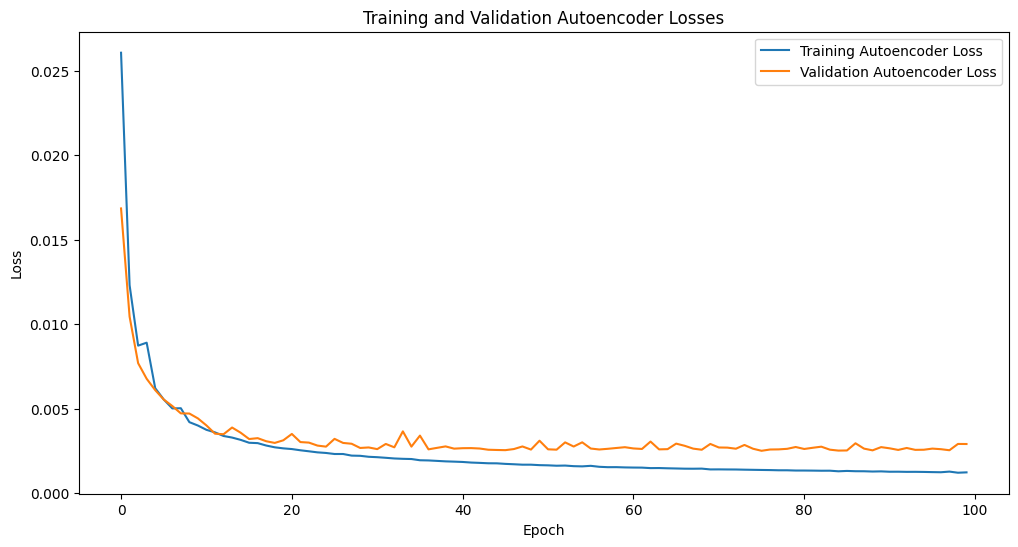

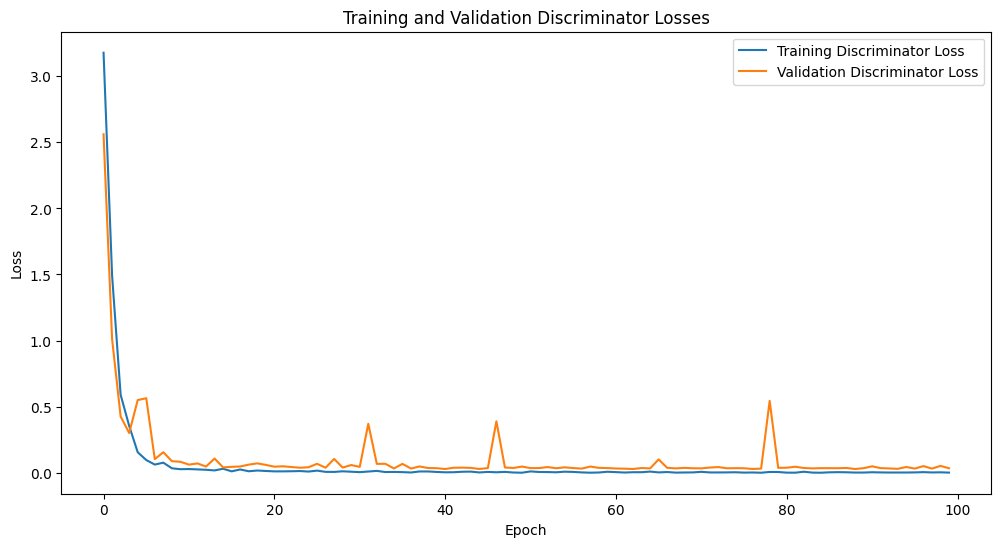

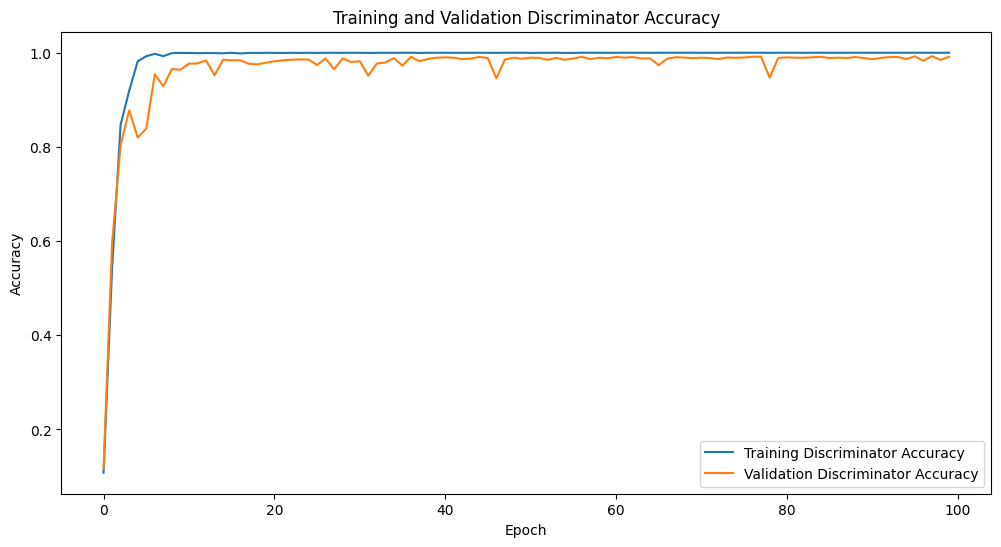

In [10]:
import matplotlib.pyplot as plt

# Plot autoencoder losses
plt.figure(figsize=(12, 6))
plt.plot(autoencoder_losses_epoch, label='Training Autoencoder Loss')
plt.plot(val_autoencoder_losses_epoch, label='Validation Autoencoder Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Autoencoder Losses')
plt.legend()
plt.savefig('autoencoder_losses.png')  # Save the plot as an image
plt.show()

# Plot discriminator losses
plt.figure(figsize=(12, 6))
plt.plot(discriminator_losses_epoch, label='Training Discriminator Loss')
plt.plot(val_discriminator_losses_epoch, label='Validation Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Discriminator Losses')
plt.legend()
plt.savefig('discriminator_losses.png')  # Save the plot as an image
plt.show()

# Plot discriminator accuracy
plt.figure(figsize=(12, 6))
plt.plot(discriminator_acc_epoch, label='Training Discriminator Accuracy')
plt.plot(val_discriminator_acc_epoch, label='Validation Discriminator Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Discriminator Accuracy')
plt.legend()
plt.savefig('discriminator_accuracy.png')  # Save the plot as an image
plt.show()


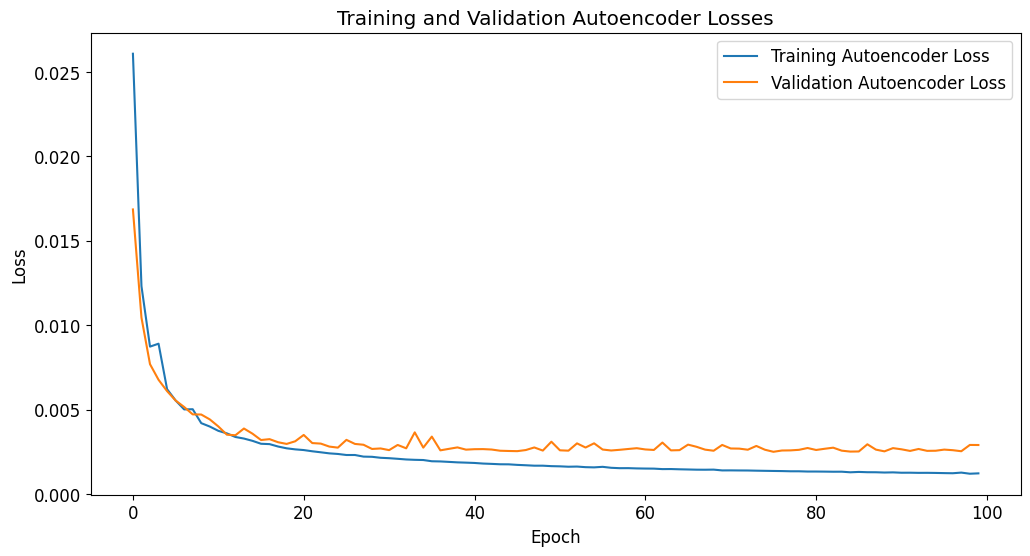

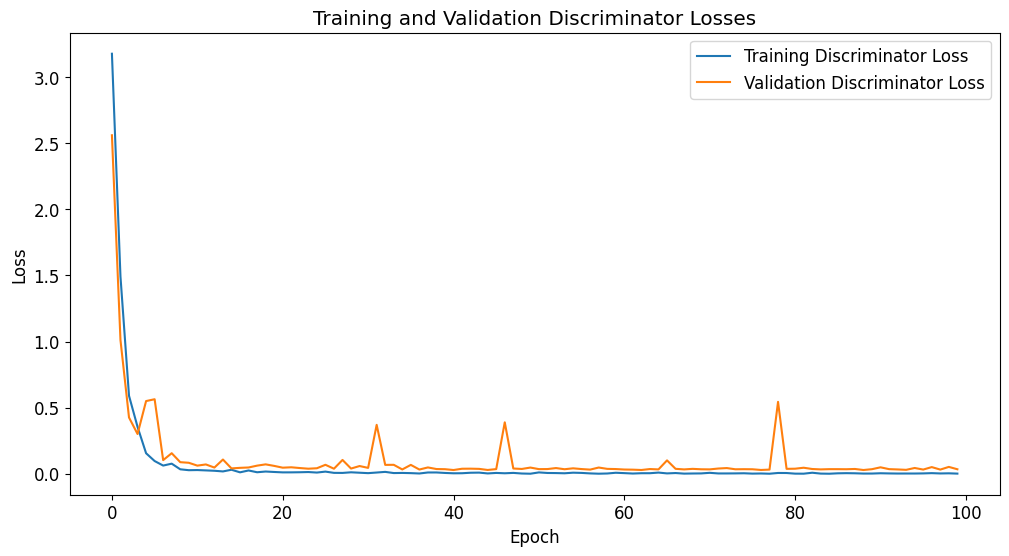

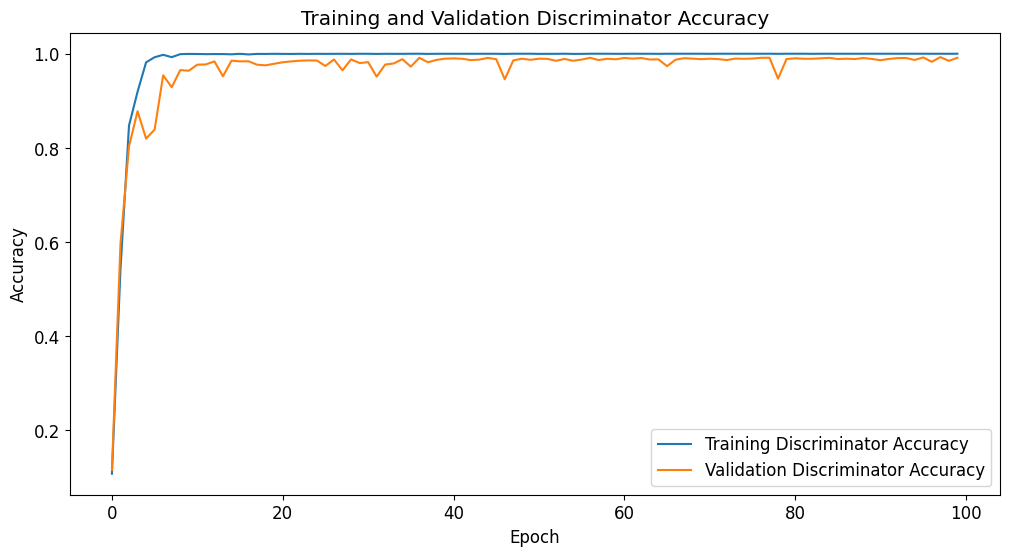

In [11]:
import matplotlib.pyplot as plt
from matplotlib import rcParams

# Set font properties
rcParams['font.family'] = 'Times New Roman'
rcParams['font.size'] = 12

# Plot autoencoder losses
plt.figure(figsize=(12, 6))
plt.plot(autoencoder_losses_epoch, label='Training Autoencoder Loss')
plt.plot(val_autoencoder_losses_epoch, label='Validation Autoencoder Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Autoencoder Losses')
plt.legend()
plt.savefig('autoencoder_losses12.png')  # Save the plot as an image
plt.show()

# Plot discriminator losses
plt.figure(figsize=(12, 6))
plt.plot(discriminator_losses_epoch, label='Training Discriminator Loss')
plt.plot(val_discriminator_losses_epoch, label='Validation Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Discriminator Losses')
plt.legend()
plt.savefig('discriminator_losses12.png')  # Save the plot as an image
plt.show()

# Plot discriminator accuracy
plt.figure(figsize=(12, 6))
plt.plot(discriminator_acc_epoch, label='Training Discriminator Accuracy')
plt.plot(val_discriminator_acc_epoch, label='Validation Discriminator Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Discriminator Accuracy')
plt.legend()
plt.savefig('discriminator_accuracy12.png')  # Save the plot as an image
plt.show()


In [12]:
# Evaluate the discriminator on the train data
result = discriminator.evaluate(train_dataset)

# Print the result
print(f'Train Result: {result}')


 10/491 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 1.0000 - loss: 5.2573e-06

I0000 00:00:1716135193.596133      77 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1716135193.614067      77 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


491/491 ━━━━━━━━━━━━━━━━━━━━ 21s 35ms/step - accuracy: 1.0000 - loss: 2.6900e-06
Train Result: [2.5218982955266256e-06, 1.0]


In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Convert numerical class labels to strings
# Define the path to the test images
import pandas as pd
df = pd.read_csv('/kaggle/input/gtsrb-german-traffic-sign/Test.csv')
test_dir = '/kaggle/input/gtsrb-german-traffic-sign/'

df['ClassId'] = df['ClassId'].astype(str)

# Define image data generator with preprocessing steps for test data
test_datagen = ImageDataGenerator(rescale=1./255)

# Flow from dataframe to preprocess test images
test_generator = test_datagen.flow_from_dataframe(
    df,
    directory=test_dir,
    x_col='Path',
    y_col='ClassId',
    target_size=(48,48),
    batch_size=len(df),
    class_mode='categorical',  # 'categorical' returns one-hot encoded labels
    shuffle=False  # Do not shuffle for evaluation
)

# Get preprocessed test images and labels
X_test, y_test = next(test_generator)


Found 12630 validated image filenames belonging to 43 classes.


In [14]:
#130 epoch 93 percent

In [15]:
# Evaluate the discriminator on the test data   ##100 epoch
result = discriminator.evaluate(X_test, y_test)

# Print the result
print(f'Test Result: {result}')


395/395 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9501 - loss: 0.3242
Test Result: [0.31960123777389526, 0.9505146741867065]


W0000 00:00:1716135380.677743      75 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [16]:
# Evaluate the discriminator on the test data   #125 epoch
result = discriminator.evaluate(X_test, y_test)

# Print the result
print(f'Test Result: {result}')


395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9501 - loss: 0.3242
Test Result: [0.31960123777389526, 0.9505146741867065]


In [17]:
# Evaluate the discriminator on the test data  ##145 epoch
result = discriminator.evaluate(X_test, y_test)

# Print the result
print(f'Test Result: {result}')


395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9501 - loss: 0.3242
Test Result: [0.31960123777389526, 0.9505146741867065]


In [18]:
import shutil
import os

# Specify the folder path
folder_path = '/kaggle/working/empty_folderf3'

# Create a zip file
shutil.make_archive(folder_path, 'zip', folder_path)

# Move the zip file to the output directory
output_path = '/kaggle/working/without_aug2.zip'
shutil.move(folder_path + '.zip', output_path)

# Display the download link
output_path
   

'/kaggle/working/without_aug2.zip'

In [19]:
discriminator.save('d_aug_valf.h5')

In [20]:
from sklearn.metrics import precision_recall_fscore_support

# Assuming you have test data predictions stored in y_pred and true labels in y_true
y_pred = discriminator.predict(X_test)
y_true = np.argmax(y_test, axis=1)  # Convert one-hot encoded labels to class labels

# Convert predicted probabilities to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Calculate precision, recall, f1-score, and support for each class
precision, recall, f1_score, support = precision_recall_fscore_support(y_true, y_pred_labels)

# Average precision, recall, f1-score across all classes
avg_precision = np.mean(precision)
avg_recall = np.mean(recall)
avg_f1_score = np.mean(f1_score)

# Print results
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)
print("Support:", support)
print("Average Precision:", avg_precision)
print("Average Recall:", avg_recall)
print("Average F1 Score:", avg_f1_score)


395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


W0000 00:00:1716135430.488000      77 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Precision: [0.84126984 0.94623656 0.98192771 0.90153173 0.97891566 0.99582173
 0.97463768 0.93333333 0.97402597 1.         0.96501458 0.80821918
 0.97404372 0.73170732 0.94117647 0.94871795 0.95588235 0.77
 0.94279661 0.91005291 0.6        0.88590604 0.96629213 0.92978723
 0.77922078 0.96350365 0.95238095 1.         0.97540984 0.99480519
 0.98319328 1.         0.99112426 0.85858586 0.97692308 1.
 0.98113208 0.94623656 0.95974235 1.         0.93414634 0.8407767
 0.97546012]
Recall: [0.88333333 0.97777778 0.98787879 0.98095238 0.94202899 0.99305556
 0.9962963  1.         1.         0.95       0.84871795 0.98333333
 0.95066667 1.         0.71111111 0.925      0.86666667 0.85555556
 0.92708333 0.95555556 0.5        0.88       0.95555556 0.97111111
 0.8        0.97777778 1.         0.9952381  0.99166667 0.98205128
 0.975      0.96666667 0.97101449 0.94444444 0.96212121 0.94444444
 0.86666667 0.97777778 0.94603175 0.91333333 0.85111111 0.96222222
 0.99375   ]
F1 Score: [0.86178862 0.96174863